# Revisit Severson et al.
Peter Attia

This notebook contains most of the figures and code for our paper re-analyzing the dataset in
[Severson et al.](https://energy.stanford.edu/sites/g/files/sbiybj9971/f/346501527888d799d94279cfe74049fde53ca2d5a1275d083d28f925253cf657.pdf)

In [1]:
import os
import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

from scipy.stats import skew, kurtosis
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

Set plotting settings:

In [2]:
fig_width = 3.25 # ECS spec is 3.25" width
fig_height = (3 / 4) * fig_width # standard ratio
figsize = (fig_width, fig_height)

fig_width_2col = 7
fig_height_2col = (3 / 4) * fig_width
figsize_2col = (fig_width_2col, fig_height_2col)

rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Set path for saving figures:

In [3]:
figpath = Path.cwd() / 'figs'

## Load data
The data is stored in the `data` directory. The data was generated by the `generate_voltage_array.m` MATLAB script, which creates three folders of "voltage arrays" for the train, test1, and test2 splits in Severson et al.

We will load each dataset as 3D arrays of (cell idx, voltage position, cycle number).

In [4]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob('./data/' + folder + '/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

Load three datasets (`test1` = primary test set, `test2` = secondary test set):

In [5]:
train_data = load_dataset('train')
test1_data = load_dataset('test1')
test2_data = load_dataset('test2')

Load cycle lives:

In [6]:
train_cycle_lives = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
test1_cycle_lives = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
test2_cycle_lives = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

Define `y` values as log10 of cycle life:

In [7]:
y_train = np.log10(train_cycle_lives)
y_test1 = np.log10(test1_cycle_lives)
y_test2 = np.log10(test2_cycle_lives)

### Voltage array illustration

This figure illustrates the voltage array (V vs. Q & cycle number) concept.

In [8]:
# Find sample cell
cellNum = 19
sample = train_data[cellNum,:,:]

# Define linearly spaced voltage vector
Vdlin = np.linspace(3.6, 2, 1000)

# Define Qsub and Qdiv (normalized to cycle 2)
Qsub = (sample[:,:].T - sample[:,0]).T
Qdiv = (sample[:,:].T / sample[:,0]).T

# Set cell indices
idx1 = 220
idx2 = 400

Make figure:

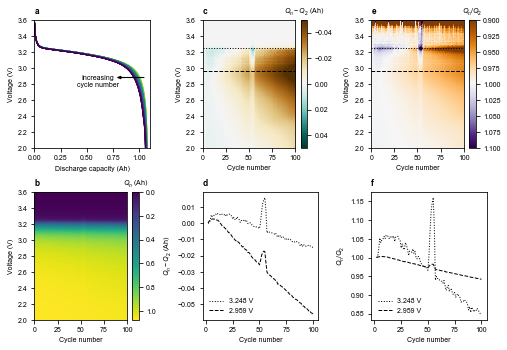

In [9]:
plt.subplots(figsize=(fig_width_2col, 2 * fig_height_2col),
             nrows=2, ncols=3)

colors = cm.get_cmap('viridis_r')(np.linspace(0, 1, 99))

# Panel A: Voltage curves
plt.subplot(231)
plt.title('a', loc='left', weight='bold')

for k in np.arange(99):
    plt.plot(sample[:,k], Vdlin, color=colors[k])
plt.xlabel('Discharge capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.xlim((0,1.1))
plt.ylim((2,3.6))
plt.arrow(0.95, 0.55, -0.2, 0, transform=plt.gca().transAxes, 
          zorder=3, head_width=0.02, color='k')
plt.text(0.55, 0.52, 'Increasing\ncycle number', horizontalalignment='center',
     verticalalignment='center',transform=plt.gca().transAxes)

# Panel B: Voltage matrix
plt.subplot(234)
plt.imshow(sample, extent=[0,100,3.6,2.0], aspect='auto', origin='lower')
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_title(r'$Q_n$'+' (Ah)',fontsize=7)
cbar.ax.invert_yaxis() 
plt.title('b',loc='left',weight='bold')

# Panel C: Qn - Q2
plt.subplot(232)
plt.title('c', loc='left', weight='bold')
plt.imshow(Qsub, extent=[0, 100, 3.6, 2.0], aspect='auto',
           cmap='BrBG', origin='lower', vmin=-0.05, vmax=0.05)
plt.axhline(Vdlin[idx1], color='k', ls=':')
plt.axhline(Vdlin[idx2], color='k', ls='--')
plt.gca().invert_yaxis()
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
cbar = plt.colorbar()
cbar.ax.set_title(r'$Q_n-Q_2$'+' (Ah)',fontsize=7)
cbar.ax.invert_yaxis() 

# Panel D: Qn - Q2
plt.subplot(235)
plt.title('d', loc='left', weight='bold')
plt.plot(np.arange(2, 101), Qsub[idx1,:], 'k', ls=':', label=f'{Vdlin[idx1]:0.3f} V')
plt.plot(np.arange(2, 101), Qsub[idx2,:], 'k', ls='--', label=f'{Vdlin[idx2]:0.3f} V')
plt.xlabel('Cycle number')
plt.ylabel(r'$Q_n-Q_2$'+' (Ah)')
plt.legend()

# Panel E: Qn / Q2
plt.subplot(233)
plt.title('e', loc='left', weight='bold')
np.savetxt('Qdiv.csv', Qdiv, delimiter=',')
im = plt.imshow(Qdiv, extent=[0,100,3.6,2.0], aspect='auto',
                origin='lower', vmin=0.9, vmax=1.1, cmap='PuOr')
plt.axhline(Vdlin[idx1], color='k', ls=':')
plt.axhline(Vdlin[idx2], color='k', ls='--')
plt.gca().invert_yaxis()
plt.xlabel('Cycle number')
plt.ylabel('Voltage (V)')
cbar = plt.colorbar(im, ax=plt.gca())
cbar.ax.set_title(r'$Q_n/Q_2$', fontsize=7)
cbar.ax.invert_yaxis() 

# Panel F: Qn / Q2
plt.subplot(236)
plt.title('f', loc='left', weight='bold')
plt.plot(np.arange(2, 101), Qdiv[idx1,:], 'k', ls=':', label=f'{Vdlin[idx1]:0.3f} V')
plt.plot(np.arange(2, 101), Qdiv[idx2,:], 'k', ls='--', label=f'{Vdlin[idx2]:0.3f} V')
plt.xlabel('Cycle number')
plt.ylabel(r'$Q_n/Q_2$')
plt.legend(loc='lower left')

# save
plt.tight_layout()
plt.savefig(figpath / 'fig1.eps', format='eps')

Similar information, but $Q_n / Q_2$ appears more sensitive to temperature fluctuations at its most sensitive point.

## Sampling frequency

How frequently do we need to sample the voltage matrix in the voltage dimension?

Define sampling frequencies for illustration plot:

In [10]:
sample_cycle = Qsub[:, 98] # Q100 - Q2

sampling_frequencies = [1, 2, 4, 10, 20, 40, 100, 200, 400]
mV_frequencies = (3.6 - 2.0) / (1000 / np.array(sampling_frequencies)) * 1000

Train model on 

In [11]:
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

train_RMSE = np.zeros((len(sampling_frequencies, )))
test1_RMSE = np.zeros((len(sampling_frequencies, )))
test2_RMSE = np.zeros((len(sampling_frequencies, )))

for k, freq in enumerate(sampling_frequencies):
    
    # Define the log10 of the variance of Q100 - Q10, with different sampling frequencies:
    X_train = np.log10(np.var((train_data[:, ::freq, 98] - train_data[:, ::freq, 8]), axis=1))
    X_test1 = np.log10(np.var((test1_data[:, ::freq, 98] - test1_data[:, ::freq, 8]), axis=1))
    X_test2 = np.log10(np.var((test2_data[:, ::freq, 98] - test2_data[:, ::freq, 8]), axis=1))

    # Scale via standarization:
    scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
    X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
    X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
    X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

    # Define and fit elastic net:
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
    enet.fit(X_train_scaled.reshape(-1, 1), y_train)
    print(f'Alpha = {enet.alpha_:0.3g}, Intercept={enet.intercept_:0.3f}')
    
    # Predict on test sets:
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)
    
    train_RMSE[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
    test1_RMSE[k] = mean_squared_error(np.power(10, y_test1), np.power(10, y_test1_pred)) ** 0.5
    test2_RMSE[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5

Alpha = 0.000146, Intercept=2.794
Alpha = 0.000146, Intercept=2.794
Alpha = 0.000146, Intercept=2.794
Alpha = 0.000146, Intercept=2.794
Alpha = 0.000146, Intercept=2.794
Alpha = 0.000146, Intercept=2.794
Alpha = 0.000145, Intercept=2.794
Alpha = 0.00726, Intercept=2.794
Alpha = 0.0136, Intercept=2.794


Confirm models match up with Table 1: RMSE = (103, 138, 196)

In [12]:
train_RMSE[0], test1_RMSE[0], test2_RMSE[0]

(103.62360099328558, 137.99572573826507, 196.00155811896215)

Looks good, just a very minor difference in training error (103 vs 104)

In [13]:
train_RMSE_percent_change = 100 * train_RMSE / train_RMSE[0] - 100
test1_RMSE_percent_change = 100 * test1_RMSE / test1_RMSE[0] - 100
test2_RMSE_percent_change = 100 * test2_RMSE / test2_RMSE[0] - 100

Make figure:

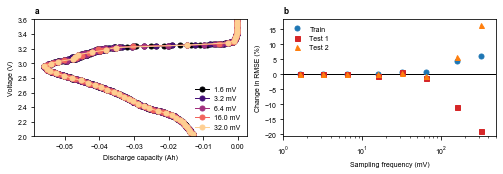

In [14]:
colors = cm.get_cmap('magma')(np.linspace(0, 0.9, 5))

fig, ax = plt.subplots(figsize=(fig_width_2col, fig_height_2col),
                       nrows=1, ncols=2)
ax = ax.ravel()

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

# Panel A
for k, freq in enumerate(sampling_frequencies[:5]):
    
    ax[0].plot(sample_cycle[::freq], Vdlin[::freq],
              '-o', color=colors[k], label=f'{mV_frequencies[k]} mV')

ax[0].set_ylim([2.0, 3.6])
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()

# Panel B
ax[1].semilogx(mV_frequencies, train_RMSE_percent_change, 'o', color='tab:blue', label='Train', zorder=2)
ax[1].semilogx(mV_frequencies, test1_RMSE_percent_change, 's', color='tab:red', label='Test 1', zorder=2)
ax[1].semilogx(mV_frequencies, test2_RMSE_percent_change, '^', color='tab:orange', label='Test 2', zorder=2)
ax[1].axhline(0, color='k', zorder=1)
ax[1].set_xlim([1, 500])
ax[1].set_xlabel('Sampling frequency (mV)')
ax[1].set_ylabel('Change in RMSE (%)')
ax[1].legend()
    
# save
plt.tight_layout()
plt.savefig(figpath / 'fig2.eps', format='eps')

## Univariate transformations

Yo yo yo

In [15]:
freq = 20

functions = {f'{Vdlin[::freq][-1]:0.3f}V':         lambda x: x[:, -1],
             f'{Vdlin[::freq][11]:0.3f}V':         lambda x: x[:, 11],
             f'{Vdlin[::freq][20]:0.3f}V':         lambda x: x[:, 20],
             'Min' :           lambda x: np.min(x, axis=1),
             'Range' :         lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'Mean':           lambda x: np.mean(x, axis=1),
             'Median':         lambda x: np.median(x, axis=1),
             'Std':            lambda x: np.std(x, axis=1),
             'Var':            lambda x: np.var(x, axis=1),
             'Skew':           lambda x: skew(x, axis=1),
             'Kurt':           lambda x: kurtosis(x, axis=1),
             'log10(min)':     lambda x: np.log10(np.min(x, axis=1) - 1.01*np.min(np.min(x, axis=1))),
             'log10(-min)':    lambda x: np.log10(-np.min(x, axis=1)),
             'log10(range)':   lambda x: np.log10(np.max(x, axis=1) - np.min(x, axis=1)),
             'range**0.5':     lambda x: np.power(np.max(x, axis=1) - np.min(x, axis=1), 0.5),
             'log10(mean)':    lambda x: np.log10(np.mean(x, axis=1) - 1.01*np.min(np.mean(x, axis=1))),
             'log10(median)':  lambda x: np.log10(np.median(x, axis=1) - 1.01*np.min(np.median(x, axis=1))),
             'log10(-mean)':   lambda x: np.log10(-np.mean(x, axis=1)),
             'log10(-median)': lambda x: np.log10(-np.median(x, axis=1)),
             'log10(std)':     lambda x: np.log10(np.std(x, axis=1)),
             'log10(var)':     lambda x: np.log10(np.var(x, axis=1)),
             'var**0.5':       lambda x: np.power(np.var(x, axis=1), 0.5),
             'log10(var)2':    lambda x: np.log10(np.var(x, axis=1) - 0.99*np.min(np.var(x, axis=1))),
             'log10(skew)':    lambda x: np.log10(skew(x, axis=1) - 1.01*np.min(skew(x, axis=1))),
             'log10(kurt)':    lambda x: np.log10(kurtosis(x, axis=1) - 1.01*np.min(kurtosis(x, axis=1))),
            }

0, 2.030V: Alpha = 0.184, Intercept=2.794
1, 3.248V: Alpha = 0.000102, Intercept=2.794
2, 2.959V: Alpha = 0.0929, Intercept=2.794
3, Min: Alpha = 0.127, Intercept=2.794
4, Range: Alpha = 0.136, Intercept=2.794
5, Mean: Alpha = 0.172, Intercept=2.794
6, Median: Alpha = 0.159, Intercept=2.794
7, Std: Alpha = 0.113, Intercept=2.794
8, Var: Alpha = 0.219, Intercept=2.794
9, Skew: Alpha = 9.96e-05, Intercept=2.794
10, Kurt: Alpha = 0.253, Intercept=2.794
11, log10(min): Alpha = 0.168, Intercept=2.794
12, log10(-min): Alpha = 0.000145, Intercept=2.794
13, log10(range): Alpha = 0.000145, Intercept=2.794
14, range**0.5: Alpha = 0.00138, Intercept=2.794
15, log10(mean): Alpha = 0.151, Intercept=2.794
16, log10(median): Alpha = 0.153, Intercept=2.794
17, log10(-mean): Alpha = 0.000142, Intercept=2.794
18, log10(-median): Alpha = 0.00342, Intercept=2.794
19, log10(std): Alpha = 0.000146, Intercept=2.794
20, log10(var): Alpha = 0.000146, Intercept=2.794


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21, var**0.5: Alpha = 0.113, Intercept=2.794


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


22, log10(var)2: Alpha = 0.0773, Intercept=2.794


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


23, log10(skew): Alpha = 0.0702, Intercept=2.794


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


24, log10(kurt): Alpha = 0.482, Intercept=2.794


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


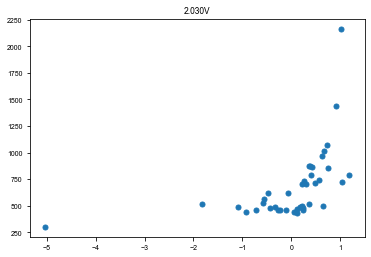

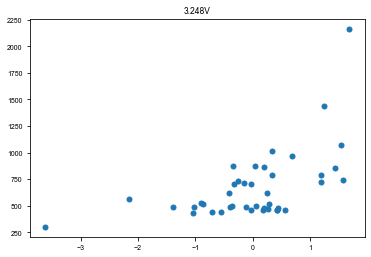

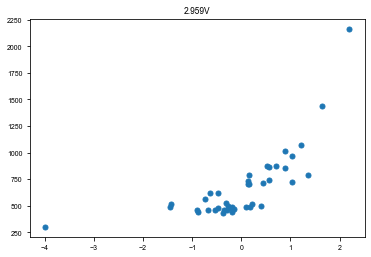

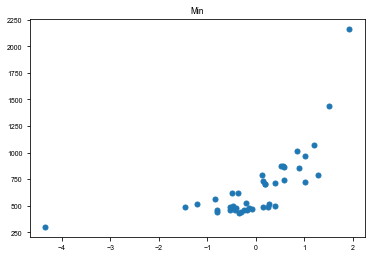

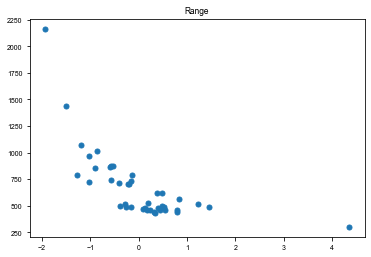

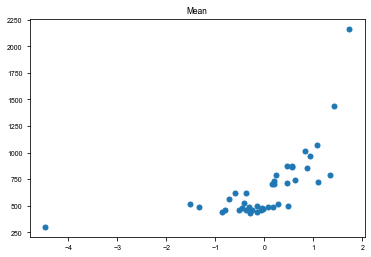

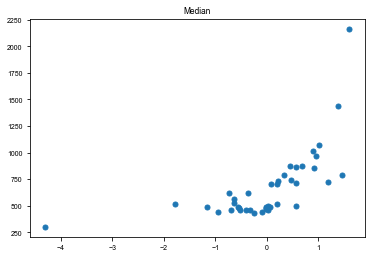

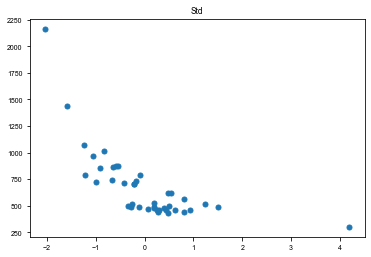

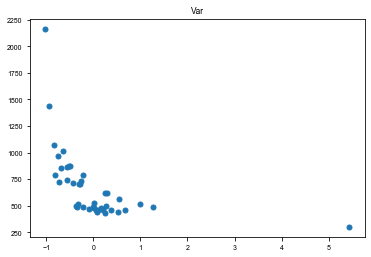

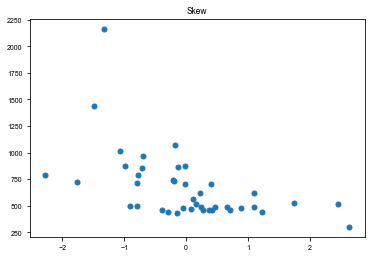

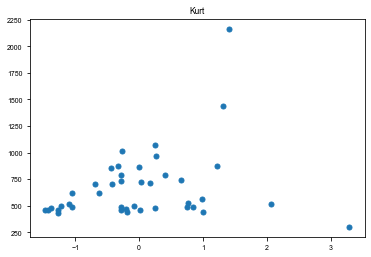

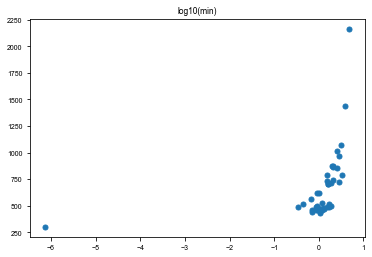

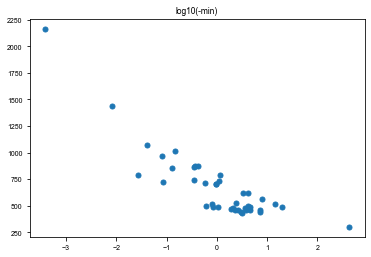

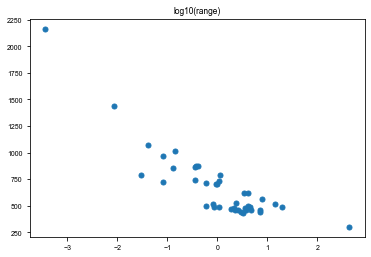

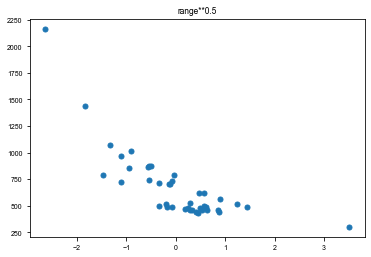

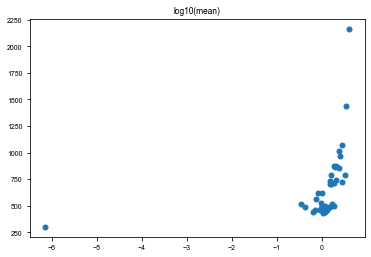

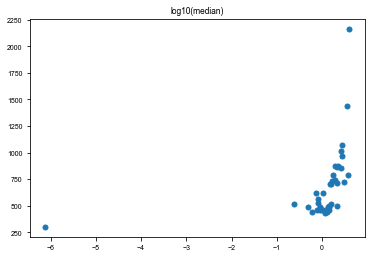

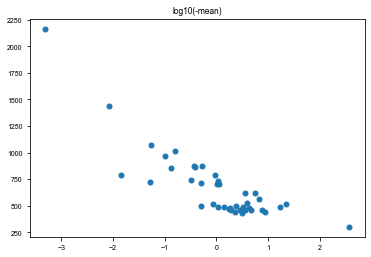

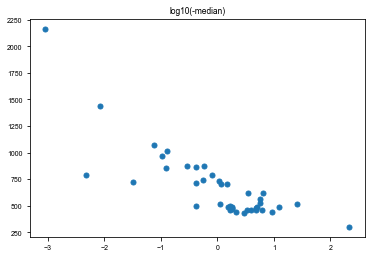

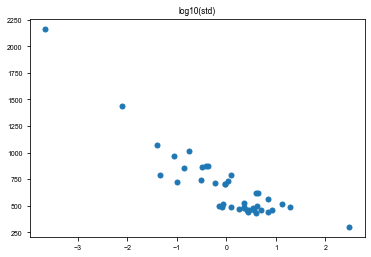

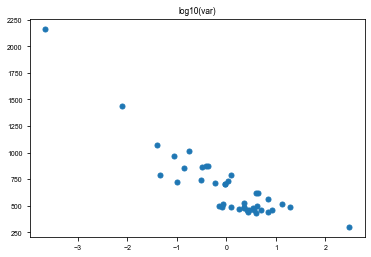

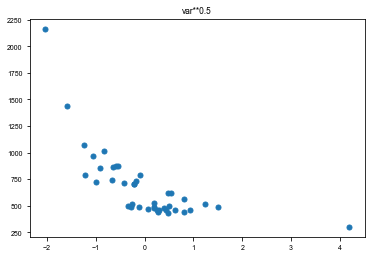

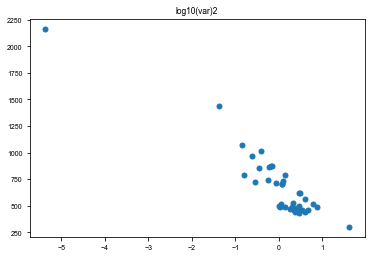

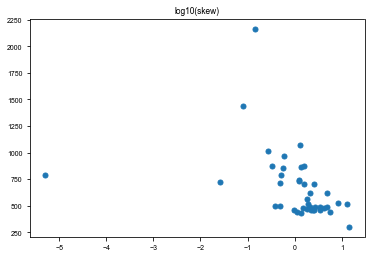

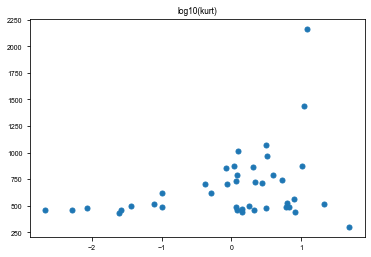

In [16]:
train_RMSE = np.zeros((len(functions, )))
test1_RMSE = np.zeros((len(functions, )))
test2_RMSE = np.zeros((len(functions, )))


for k, func in enumerate(functions):
    
    # Define the log10 of the variance of Q100 - Q10, with different sampling frequencies:
    X_train = functions[func](train_data[:, ::freq, 98] - train_data[:, ::freq, 8])
    X_test1 = functions[func](test1_data[:, ::freq, 98] - test1_data[:, ::freq, 8])
    X_test2 = functions[func](test2_data[:, ::freq, 98] - test2_data[:, ::freq, 8])
    
    # Scale via standarization:
    scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
    X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
    X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
    X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

    # Define and fit elastic net:
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
    enet.fit(X_train_scaled.reshape(-1, 1), y_train)
    print(f'{k}, {func}: Alpha = {enet.alpha_:0.3g}, Intercept={enet.intercept_:0.3f}')
    
    # Predict on test sets:
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)
    
    train_RMSE[k] = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred)) ** 0.5
    test1_RMSE[k] = mean_squared_error(np.power(10, y_test1), np.power(10, y_test1_pred)) ** 0.5
    test2_RMSE[k] = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred)) ** 0.5
    
    
    plt.figure()
    plt.plot(X_train_scaled, train_cycle_lives, 'o')
    plt.title(func)

In [17]:
train_RMSE2 = np.zeros((len(functions, )))
test1_RMSE2 = np.zeros((len(functions, )))
test2_RMSE2 = np.zeros((len(functions, )))

skews = np.zeros((len(functions, )))

for k, func in enumerate(functions):
    
    # Define the log10 of the variance of Q100 - Q10, with different sampling frequencies:
    X_train = functions[func](train_data[:, ::freq, 98] - train_data[:, ::freq, 8])
    X_test1 = functions[func](test1_data[:, ::freq, 98] - test1_data[:, ::freq, 8])
    X_test2 = functions[func](test2_data[:, ::freq, 98] - test2_data[:, ::freq, 8])
    
    # Scale via standarization:
    scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
    X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
    X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
    X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

    # Define and fit elastic net:
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
    enet.fit(X_train_scaled.reshape(-1, 1), train_cycle_lives)
    
    # Predict on test sets:
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)
    
    train_RMSE2[k] = mean_squared_error(train_cycle_lives, y_train_pred) ** 0.5
    test1_RMSE2[k] = mean_squared_error(test1_cycle_lives, y_test1_pred) ** 0.5
    test2_RMSE2[k] = mean_squared_error(test2_cycle_lives, y_test2_pred) ** 0.5
    
    # 
    skews[k] = skew(X_train)
    print(f'{k}, {func}: Skew(train) = {skew(X_train):0.3f}, RMSE(train) = {train_RMSE2[k]:0.3f}, Alpha = {enet.alpha_:0.3g}, Intercept={enet.intercept_:0.3f}')

0, 2.030V: Skew(train) = -3.166, RMSE(train) = 289.734, Alpha = 1.25, Intercept=673.756
1, 3.248V: Skew(train) = -1.042, RMSE(train) = 267.901, Alpha = 0.19, Intercept=673.756
2, 2.959V: Skew(train) = -1.190, RMSE(train) = 232.354, Alpha = 0.821, Intercept=673.756
3, Min: Skew(train) = -1.724, RMSE(train) = 247.304, Alpha = 1.02, Intercept=673.756
4, Range: Skew(train) = 1.733, RMSE(train) = 247.256, Alpha = 1.02, Intercept=673.756
5, Mean: Skew(train) = -1.993, RMSE(train) = 258.078, Alpha = 1.11, Intercept=673.756
6, Median: Skew(train) = -1.803, RMSE(train) = 260.143, Alpha = 1.09, Intercept=673.756
7, Std: Skew(train) = 1.488, RMSE(train) = 240.196, Alpha = 0.915, Intercept=673.756
8, Var: Skew(train) = 3.888, RMSE(train) = 288.526, Alpha = 1.38, Intercept=673.756
9, Skew: Skew(train) = 0.395, RMSE(train) = 272.871, Alpha = 0.285, Intercept=673.756
10, Kurt: Skew(train) = 0.870, RMSE(train) = 323.129, Alpha = 795, Intercept=673.756
11, log10(min): Skew(train) = -5.604, RMSE(train) 

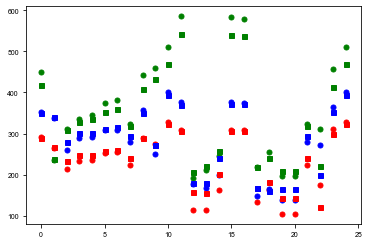

In [18]:
plt.plot(train_RMSE, 'or')
plt.plot(test1_RMSE, 'ob')
plt.plot(test2_RMSE, 'og')

plt.plot(train_RMSE2, 'sr')
plt.plot(test1_RMSE2, 'sb')
plt.plot(test2_RMSE2, 'sg')

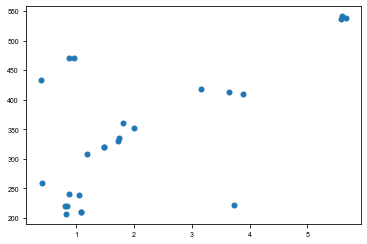

In [23]:
plt.plot(np.abs(skews), test2_RMSE2, 'o')